# Thanker Experiment Report Feb 2020
[J. Nathan Matias](https://natematias.com), [Citizens and Technology Lab](https://citizensandtech.org)


### References
* [Experiment Plan: The Effect of Sending Thanks on Wikipedia](https://osf.io/e5r3q/)


# Analysis Code

In [442]:
## Load Libraries
library(ggplot2)
library(ggpubr)  # contains ggarrange
library(gmodels) # contains CrossTable
library(estimatr)
library(corrplot)
library(lme4)
library(broom)
library(knitr)
library(lmerTest)
library(texreg)

## Set visual style
catpalette   <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
chartpalette <- c("#ea5324", "#005073", "#7D868C", "#333333", "#F2F2F2","#BDBBBB", "#F6F2EB")

cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=13, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]))
options(repr.plot.width=6, repr.plot.height=4.5)

### Load Experiment Results Data

In [443]:
data.dir = "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thanker_hardlaunch/post_experiment_analysis/"
filename = "all-pre_and_post_treatment_vars_with_post_survey_R_columns.csv"
participant <- read.csv(paste(data.dir, filename, sep=""))

## 38 participants accessed & used the system before the experiment started
## we have assigned them randomization.block.id = -1 and omitted them from the analysis
participant <- subset(participant, randomization.block.id!=-1)

participant$complier <- participant$complier == "True"
participant$complier.int <- as.integer(participant$complier)
participant$complier.app.int <- as.integer(participant$complier.app=="True")
participant$complier.app.logged.in.int <- as.integer(participant$complier.app.logged.in=="True")
participant$TREAT <- participant$randomization.arm

## inclusive compliers are participants that:
### among control, logged in
### among treatment, completed the task
participant$complier.app.inclusive <- (participant$T==1 & participant$complier.app=="True") | 
                                         (participant$TREAT==0 & participant$complier.app.logged.in=="True")


participant$diff.labor.hours <- participant$labor.hours.56.post.treatment - participant$labor.hours.56.pre.treatment

participant$diff.newcomer.capability <- participant$post.newcomer.capability - participant$pre.newcomer.capability
participant$diff.newcomer.intent <- participant$post.newcomer.intent - participant$pre.newcomer.intent

participant$diff.thanks.sent <- participant$wikithanks.56.post.treatment - participant$wikithanks.56.pre.treatment

participant$diff.emotionally.draining <- participant$post.emotionally.draining - participant$pre.emotionally.draining
participant$diff.monitoring.damaging.content <- participant$post.monitoring.damaging.content - participant$pre.monitoring.damaging.content
participant$diff.mentoring <- participant$post.mentoring - participant$pre.mentoring

## ZEROED OUT SURVEY PREDICTORS
participant$pre.emotionally.draining.zeroed <- participant$pre.emotionally.draining-3
participant$previous.positive.feeling.zeroed <- participant$previous.positive.feeling-3

## individual participants that complied with the app
behavioral.compliers.exclusive <- subset(participant, complier.app!="False")
behavioral.compliers.inclusive <- subset(participant, complier.app.inclusive)
behavioral.compliers.login <- subset(participant, complier.app.logged.in!="False")

## individual participants that complied with the survey
survey.compliers <- subset(participant, complier)

## dataframe with a sum of how many block members complied
behavioral.block.compliance <- aggregate(participant[c('complier.app.logged.in.int')], by=list(participant$randomization.block.id), FUN=sum)
survey.block.compliance <- aggregate(participant[c('complier.int')], by=list(participant$randomization.block.id), FUN=sum)

## accounts in blocks where every block participant complied with the app
behavioral.block.compliers <- subset(participant, randomization.block.id %in% subset(behavioral.block.compliance, complier.app.logged.in.int==1)$Group.1)

## accounts in blocks where every block participant complied with the survey
survey.block.compliers <- subset(participant, randomization.block.id %in% subset(survey.block.compliance, complier.int==2)$Group.1)

### Load Full Initial Survey Taking Group

In [444]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thanker_hardlaunch/historical_survey_merged"
de.filename = "de-merged-20190729.csv"
ar.filename = "ar-merged-20190729.csv"
fa.filename = "fa-merged-20190729.csv"
pl.filename = "pl-merged-20190729.csv"
thankers.df <- rbind(read.csv(file.path(data.path,de.filename), sep=","),
                     read.csv(file.path(data.path,ar.filename), sep=","),
                     read.csv(file.path(data.path,pl.filename), sep=","))
fa.thankers.df <- read.csv(file.path(data.path,fa.filename), sep=",")


thankers.df <- rbind(thankers.df, 
                 fa.thankers.df[colnames(thankers.df)])

#### Zeroing 1-5 Scale Items About Activity into 0-4 scales for reporting
Note: it's important to do this *after* calculting the "diff" variables for these items.

In [445]:
if(min(participant$pre.mentoring)==1){
    participant$pre.mentoring <- participant$pre.mentoring -1
}

if(min(participant$pre.monitoring.damaging.content)==1){
    participant$pre.monitoring.damaging.content <- participant$pre.monitoring.damaging.content -1
}

if(min(participant$pre.newcomer.capability)==1){
    participant$pre.newcomer.capability <- participant$pre.newcomer.capability -1
}

if(min(participant$pre.newcomer.intent)==1){
    participant$pre.newcomer.intent <- participant$pre.newcomer.intent -1
}

#### Monitoring-Mentoring Subgroups

In [446]:
participant$mentor.monitor <- NA
participant[(participant$pre.mentoring > 0 & 
            participant$pre.monitoring.damaging.content > 0),]$mentor.monitor <- "Monitor & Mentor"
participant[(participant$pre.mentoring == 0 & 
            participant$pre.monitoring.damaging.content > 0),]$mentor.monitor <- "Monitor Only"
participant[(participant$pre.mentoring > 0 & 
            participant$pre.monitoring.damaging.content == 0),]$mentor.monitor <- "Mentor Only"
participant[(participant$pre.mentoring == 0 & 
            participant$pre.monitoring.damaging.content == 0),]$mentor.monitor <- "Neither"
participant$mentor.monitor <- factor(participant$mentor.monitor)

In [447]:
summary(participant$mentor.monitor)

Mentor Only Monitor & Mentor     Monitor Only          Neither 
              12              148              150               90

# Introduction Analysis

### Full Group Count

In [448]:
nrow(thankers.df)

[1] 447

### Who Participated in the Study

In [449]:
print(paste(nrow(participant), "volunteers"))
print(paste(nrow(subset(participant, complier.app.logged.in=="True")), "accounts logged in"))
print(paste(nrow(subset(participant, complier.app.inclusive)), "accounts in the 'inclusive' app sample"))
print(paste(nrow(subset(participant, complier.app.int==1)), "accounts in the 'exclusive' app sample"))
print(paste(nrow(behavioral.block.compliers), "behavioral block compliers (logged in)"))
print(paste(nrow(subset(participant, complier.survey=="True")), "accounts completed post-survey"))
print(paste(sum(participant$num.thank.actions, na.rm=TRUE), "thanks sent"))
print(paste(sum(as.integer(participant$num.thank.actions > 0), na.rm=TRUE), "accounts sent thanks"))
print(paste(sum(participant$num.thankees.skipped, na.rm=TRUE), "accounts skipped"))

[1] "400 volunteers"
[1] "238 accounts logged in"
[1] "205 accounts in the 'inclusive' app sample"
[1] "154 accounts in the 'exclusive' app sample"
[1] "172 behavioral block compliers (logged in)"
[1] "140 accounts completed post-survey"
[1] "342 thanks sent"
[1] "89 accounts sent thanks"
[1] "489 accounts skipped"


[1] "Year joined"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   5.000   9.000   8.498  12.000  17.000 

[1] "Edits in the 56 days before treatment"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.75   53.50  194.56  210.00 4109.00 

[1] "Labor Hours in the 56 days before treatment"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.9106   6.4926  22.1485  27.7571 299.2500 

[1] "Reverts in the 56 days before treatment"


   Mode   FALSE    TRUE 
logical     182     218 

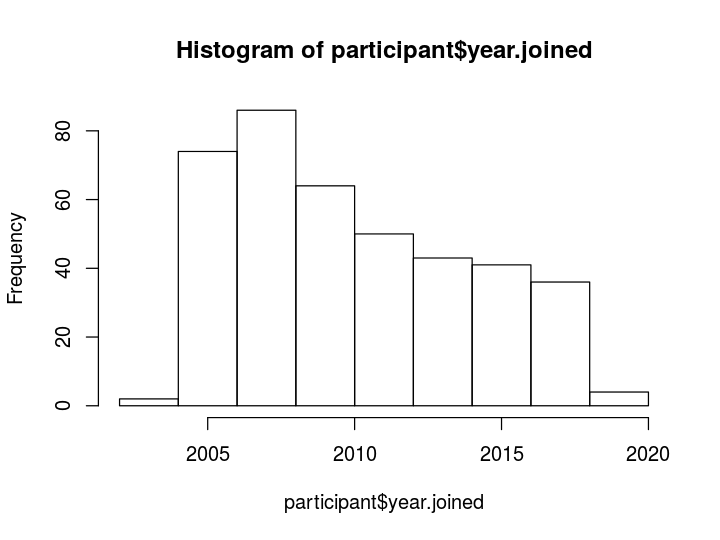

In [451]:
print("Year joined")
summary(2019-participant$year.joined)
hist(participant$year.joined)
print("Edits in the 56 days before treatment")
summary(participant$total.edits.56.pre.treatment)

print("Labor Hours in the 56 days before treatment")
summary(participant$labor.hours.56.pre.treatment)


print("Reverts in the 56 days before treatment")
summary(participant$num.reverts.56.pre.treatment>0)

## Mentoring and Monitoring

### Baseline Rates of Monitoring and Mentoring, Comparing Rates

In [365]:
summary((participant$pre.mentoring))
summary((participant$pre.monitoring))
summary(participant$pre.mentoring>3)
summary(participant$pre.monitoring>3)

t.test(participant$pre.mentoring, participant$pre.monitoring)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.5725  1.0000  4.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   1.337   2.000   4.000 

   Mode   FALSE    TRUE 
logical     393       7 

   Mode   FALSE    TRUE 
logical     385      15 


	Welch Two Sample t-test

data:  participant$pre.mentoring and participant$pre.monitoring
t = -10.769, df = 752.71, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9044501 -0.6255499
sample estimates:
mean of x mean of y 
   0.5725    1.3375 


### Correlations Between Supportive Activity, Monitoring Activity, and Mentoring Activity

In [366]:
print(paste(
    nrow(subset(participant, pre.mentoring==0)) / nrow(participant)*100, "%",
    " of participants report never doing any mentoring",
    sep=""))

print(paste(
    nrow(subset(participant, pre.monitoring.damaging.content==0)) / nrow(participant)*100, "%",
    " of participants report never doing any monitoring",
    sep=""))

print(paste(
    as.integer(nrow(subset(participant, pre.monitoring.damaging.content>0 & pre.mentoring==0)) / nrow(subset(participant, pre.monitoring.damaging.content>0))*100), "%",
    " of participants who monitor report never doing any mentoring",
    sep=""))
print("---")
print(paste(
    as.integer(nrow(subset(participant, pre.monitoring.damaging.content==0 & pre.mentoring==0)) / nrow(participant)*100), "%",
    " of participants report never doing any mentoring or monitoring",
    sep=""))


print(paste(
    as.integer(nrow(subset(participant, pre.monitoring.damaging.content>0 & pre.mentoring==0)) / nrow(participant)*100), "%",
    " of participants monitor but never do any mentoring",
    sep=""))

print(paste(
    as.integer(nrow(subset(participant, pre.monitoring.damaging.content>0 & pre.mentoring>0)) / nrow(participant)*100), "%",
    " of participants monitor and mentor",
    sep=""))

print(paste(
    as.integer(nrow(subset(participant, pre.monitoring.damaging.content==0 & pre.mentoring>0)) / nrow(participant)*100), "%",
    " of participants mentor but not monitor",
    sep=""))

[1] "60% of participants report never doing any mentoring"
[1] "25.5% of participants report never doing any monitoring"
[1] "50% of participants who monitor report never doing any mentoring"
[1] "---"
[1] "22% of participants report never doing any mentoring or monitoring"
[1] "37% of participants monitor but never do any mentoring"
[1] "37% of participants monitor and mentor"
[1] "3% of participants mentor but not monitor"


In [367]:
for(l in unique(participant$lang)){
    print(l)
    print(paste(
    round(nrow(subset(participant, pre.mentoring>0 & lang==l)) / nrow(subset(participant, lang==l))*100), "%",
    " of participants report doing some mentoring",
    sep=""))

    print("----")
}

[1] "fa"
[1] "58% of participants report doing some mentoring"
[1] "----"
[1] "de"
[1] "37% of participants report doing some mentoring"
[1] "----"
[1] "pl"
[1] "40% of participants report doing some mentoring"
[1] "----"


In [601]:
#CrossTable(participant$mentor.monitor, participant$lang,prop.chisq = FALSE ,prop.t=FALSE)
#participant$total.edits.56.pre.treatment
aggregate(participant[c("num.reverts.56.pre.treatment", 
                        "previous.supportive.actions", 
                        "labor.hours.56.pre.treatment",
                        "pre.emotionally.draining",
                        "pre.newcomer.intent",
                        "pre.newcomer.capability")], by=list(participant$mentor.monitor), FUN=mean)

print("DE")
aggregate(subset(participant, lang=="de")[c("num.reverts.56.pre.treatment", 
                        "previous.supportive.actions", 
                        "labor.hours.56.pre.treatment",
                        "pre.emotionally.draining",
                        "pre.newcomer.intent",
                        "pre.newcomer.capability")], by=list(subset(participant, lang=="de")$mentor.monitor), FUN=mean)
print("FA")
aggregate(subset(participant, lang=="fa")[c("num.reverts.56.pre.treatment", 
                        "previous.supportive.actions", 
                        "labor.hours.56.pre.treatment",
                        "pre.emotionally.draining",
                        "pre.newcomer.intent",
                        "pre.newcomer.capability")], by=list(subset(participant, lang=="fa")$mentor.monitor), FUN=mean)

print("PL")
aggregate(subset(participant, lang=="pl")[c("num.reverts.56.pre.treatment", 
                        "previous.supportive.actions", 
                        "labor.hours.56.pre.treatment",
                        "pre.emotionally.draining",
                        "pre.newcomer.intent",
                        "pre.newcomer.capability")], by=list(subset(participant, lang=="pl")$mentor.monitor), FUN=mean)


Group.1,num.reverts.56.pre.treatment,previous.supportive.actions,labor.hours.56.pre.treatment,pre.emotionally.draining,pre.newcomer.intent,pre.newcomer.capability
Mentor Only,30.250000,36.75000,16.52424,2.250000,2.916667,3.000000
Monitor & Mentor,22.155405,56.38514,34.05849,2.371622,2.655405,2.081081
Monitor Only,4.173333,19.02000,14.67421,2.246667,2.673333,2.053333
Neither,6.777778,13.24444,15.77021,1.955556,2.844444,2.022222


[1] "DE"


Group.1,num.reverts.56.pre.treatment,previous.supportive.actions,labor.hours.56.pre.treatment,pre.emotionally.draining,pre.newcomer.intent,pre.newcomer.capability
Mentor Only,28.125000,19.75000,13.93889,2.000000,2.875000,2.750000
Monitor & Mentor,14.113402,53.45361,34.86501,1.969072,2.773196,2.154639
Monitor Only,2.160377,16.00000,12.33559,1.943396,2.820755,2.047170
Neither,7.786667,15.32000,17.94439,1.946667,2.880000,1.920000


[1] "FA"


Group.1,num.reverts.56.pre.treatment,previous.supportive.actions,labor.hours.56.pre.treatment,pre.emotionally.draining,pre.newcomer.intent,pre.newcomer.capability
Mentor Only,1.00000,41.00000,19.40111,1.000000,3.000000,4.00000
Monitor & Mentor,42.93103,73.10345,30.42717,3.551724,2.310345,1.62069
Monitor Only,7.52381,24.76190,15.85205,3.190476,2.095238,1.52381
Neither,0.00000,0.00000,0.00000,2.000000,2.000000,1.00000


[1] "PL"


Group.1,num.reverts.56.pre.treatment,previous.supportive.actions,labor.hours.56.pre.treatment,pre.emotionally.draining,pre.newcomer.intent,pre.newcomer.capability
Mentor Only,45.666667,80.666667,22.459537,3.333333,3.000000,3.333333
Monitor & Mentor,30.227273,47.272727,35.289230,2.590909,2.590909,2.363636
Monitor Only,10.391304,27.695652,24.376751,2.782609,2.521739,2.565217
Neither,1.857143,3.071429,5.249286,2.000000,2.714286,2.642857


In [122]:
# ## comparing mentors to monitors in the time they spend monitoring damaging content
# mentors <- subset(participant, pre.mentoring>0)
# monitors <- subset(participant, pre.mentoring==0 & pre.monitoring.damaging.content>0)

# t.test(mentors$pre.monitoring.damaging.content, monitors$pre.monitoring.damaging.content)

In [123]:
## RELATIONSHIP BETWEEN MENTORING AND REVERTS
IRdisplay::display_html(htmlreg(pre.monitoring.reverts.lm <- lm(log1p(num.reverts.56.pre.treatment) ~ 
                                       log1p(total.edits.56.pre.treatment) + 
                                       pre.monitoring.damaging.content, 
                                       data=participant),
                               custom.model.names=c("log1p(num.reverts)"),
                               caption="Linear regression predicting log-transformed reverts from proportion of time spent monitoring damaging content, holding constant the overall rate of edits."
                               ))

,log1p(num.reverts)
(Intercept),-0.96***
,(0.11)
log1p(total.edits.56.pre.treatment),0.47***
,(0.02)
pre.monitoring.damaging.content,0.21***
,(0.04)
R2,0.54
Adj. R2,0.54
Num. obs.,400
RMSE,0.95


In [372]:
## RELATIONSHIP BETWEEN MENTORING AND Supportive Actions
IRdisplay::display_html(htmlreg(pre.mentoring.support.lm <- lm(log1p(previous.supportive.actions) ~ 
                                       log1p(total.edits.56.pre.treatment) + 
                                       pre.mentoring, 
                                       data=participant),
                               custom.model.names=c("log1p(previous.supportive.actions)"),
                               caption="Linear regression predicting log-transformed talk page + support edits from proportion of time spent monitoring damaging content, holding constant the overall rate of edits."
                               ))

,log1p(previous.supportive.actions)
(Intercept),-0.52***
,(0.11)
log1p(total.edits.56.pre.treatment),0.66***
,(0.02)
pre.mentoring,0.26***
,(0.06)
R2,0.67
Adj. R2,0.67
Num. obs.,400
RMSE,0.99


## Feeling Positive and Feeling Emotionally Drained

In [74]:
summary(participant$previous.positive.feeling)
summary(factor(participant$previous.positive.feeling))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.000   4.000   4.183   5.000   5.000 

1   2   3   4   5 
  3  16  53 161 167

In [75]:
summary(participant$pre.emotionally.draining)
summary(factor(participant$pre.emotionally.draining))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.228   3.000   5.000 

1   2   3   4   5 
122 147  65  50  16

In [532]:
IRdisplay::display_html(
    htmlreg(monitoring.positive.lm <- lm(pre.monitoring.damaging.content ~ 
           pre.emotionally.draining.zeroed + 
           previous.positive.feeling.zeroed +
           labor.hours.56.pre.treatment,
           data=participant),
       html.tag=FALSE,
       custom.model.names=c("Time Spent<br/>Monitoring"),
       custom.coef.names =c("(Intercept)", "Emotionally Drained", "Positive Feeling", "Labor Hours"),
       caption=paste("Factors Predicting Chance of Login", "<br/>",
                       "Survey of ", nrow(participant),  " contributors in DE, FA, and PL Wikipedias, June-Oct 2019.", "<br/>",
                       "Participants were recruited via banner ads & mailing lists.","<br/>",
                       "Eligible accounts included:",
                       "DE and PL: permission to flag revisions. FA: registered for 1 year & 500+ edits.", "<br/>", 
                       "© Creative Commons Attribution 4.0.", "\n",
                       "\n",
                       "Citizens & Technology Lab • ",
                       " <a href=\"https://citizensandtech.org\">www.citizensandtech.org</a>",               
                       sep=""))
)

,Time SpentMonitoring
(Intercept),1.14***
,(0.10)
Emotionally Drained,0.23***
,(0.05)
Positive Feeling,0.21**
,(0.06)
Labor Hours,0.01***
,(0.00)
R2,0.10
Adj. R2,0.09


In [81]:
summary(factor(participant$complier.app.logged.in.int))

0   1 
162 238


	Pearson's product-moment correlation

data:  participant$pre.emotionally.draining and participant$complier.app.logged.in.int
t = -2.8296, df = 398, p-value = 0.004896
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.23524280 -0.04297019
sample estimates:
       cor 
-0.1404302 


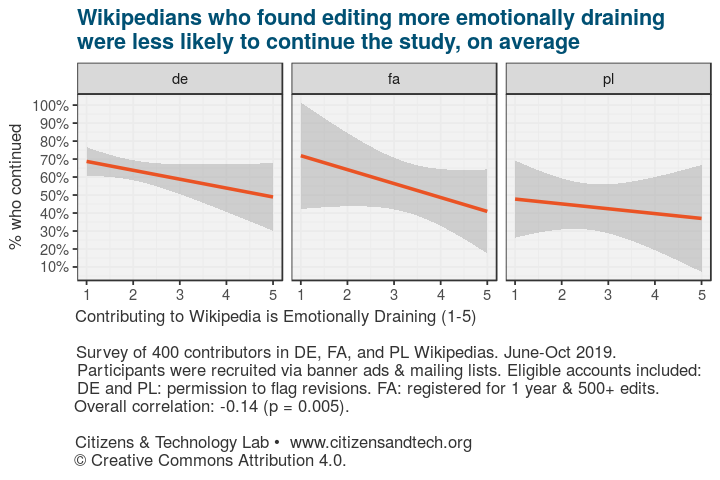

In [673]:
options(repr.plot.width=6, repr.plot.height=4)

cor.test(participant$pre.emotionally.draining, participant$complier.app.logged.in.int)

ggplot(participant, aes(pre.emotionally.draining, complier.app.logged.in.int)) +
    theme_bw() +
    geom_smooth(method='lm', color=catpalette[2]) + 
    scale_y_continuous(labels=scales::number_format(accuracy=1.0, scale=100, suffix="%"),
                       breaks=seq(0, 1, 0.1)) +
    facet_grid(. ~ lang) +
    ylab("% who continued") +
    cat.theme + 
    ggtitle(paste("Wikipedians who found editing more emotionally draining","\n",
                  "were less likely to continue the study, on average", sep="")) +
    xlab(paste("Contributing to Wikipedia is Emotionally Draining (1-5)", "\n\n", 
               "Survey of ", nrow(participant),  " contributors in DE, FA, and PL Wikipedias. June-Oct 2019.", "\n",
               "Participants were recruited via banner ads & mailing lists. Eligible accounts included:", "\n",
               "DE and PL: permission to flag revisions. FA: registered for 1 year & 500+ edits.", "\n",
               "Overall correlation: ", sprintf("%0.2f", cor(participant$pre.emotionally.draining, participant$complier.app.logged.in.int)),
               " (p = 0.005). ", "\n",
               "\n",
               "Citizens & Technology Lab • ", 
               " www.citizensandtech.org", "\n",
               "© Creative Commons Attribution 4.0.",
               sep=""))

In [ ]:
participant$labor.hours.56.pre.treatment

In [380]:
summary(lm(complier.app.logged.in.int ~ 
           pre.emotionally.draining.zeroed,
   data=participant))


Call:
lm(formula = complier.app.logged.in.int ~ pre.emotionally.draining.zeroed, 
    data = participant)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6699 -0.5478  0.3301  0.3911  0.5742 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.54785    0.02952   18.56   <2e-16 ***
pre.emotionally.draining.zeroed -0.06103    0.02157   -2.83   0.0049 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4872 on 398 degrees of freedom
Multiple R-squared:  0.01972,	Adjusted R-squared:  0.01726 
F-statistic: 8.007 on 1 and 398 DF,  p-value: 0.004896


### Views About newcomer Capability and Intent
This analysis was removed from the final post to keep it concise

In [668]:
#summary(participant$pre.newcomer.capability)
#summary(factor(participant$pre.newcomer.capability))

aggregate(participant[c("pre.newcomer.capability")],
          by=list(participant$lang), FUN=mean)

plot.newcomer.capability <- 
    ggplot(participant, aes(pre.newcomer.capability)) +
    geom_histogram(binwidth=1, aes(x = pre.newcomer.capability, y = ..density..), fill=catpalette[1]) +
    cat.theme +
    scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
    ylab("% of answers") +
    facet_grid(. ~ lang) +
    xlab(paste("View of Newcomer Capability", "\n\n",
               "Survey of 400 contributors in DE(286), FA(52), and PL(62) Wikipedias June-July 2019.","\n",
               "Recruitment via banner ads and mailing lists. Eligible accounts included: ", "\n",
               "DE & PL (permission to flag revisions), FA (registered for 1 year & 500 edits). ", "\n\n",
               "Citizens & Technology Lab • ",
               "citizensandtech.org","\n",
               "Creative Commons Attribution 4.0",
               sep="")) 
#plot.newcomer.capability

Group.1,pre.newcomer.capability
de,2.069930
fa,1.615385
pl,2.548387


In [669]:
#summary(participant$pre.newcomer.intent)
#summary(factor(participant$pre.newcomer.intent))

aggregate(participant[c("pre.newcomer.intent")],
          by=list(participant$lang), FUN=mean)

plot.newcomer.intent <- ggplot(participant, aes(pre.newcomer.intent)) +
    geom_histogram(binwidth=1, aes(x = pre.newcomer.intent, y = ..density..), 
                   fill=catpalette[2], alpha=0.8) +
    cat.theme +
    scale_y_continuous(labels = scales::percent_format( accuracy = 1)) +
    xlab(paste("View of Newcomer Intent")) +
    ylab("% of answers") +
    facet_grid(. ~ lang) +
    ggtitle(paste("Wikipedians believe newcomers have positive intent and", "\n",
                  "some capability, with opportunity to grow", 
                  sep="")
           )

Group.1,pre.newcomer.intent
de,2.821678
fa,2.230769
pl,2.612903


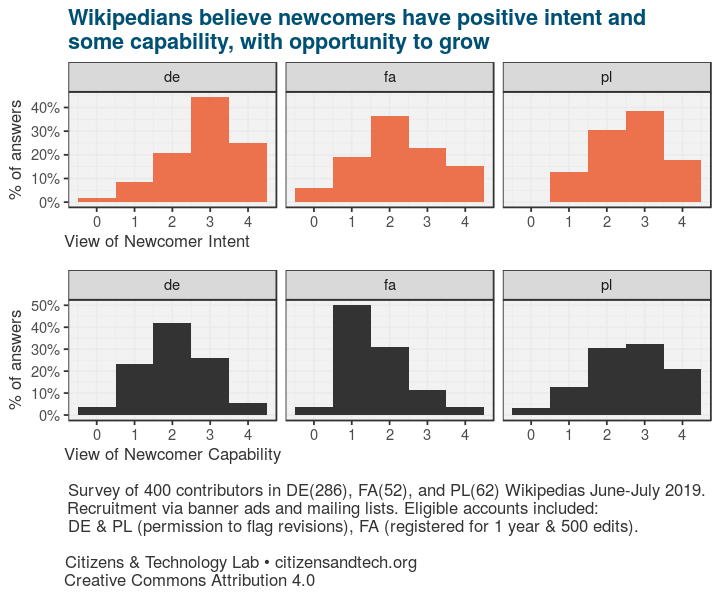

In [670]:
options(repr.plot.width=6, repr.plot.height=5)

ggarrange(plot.newcomer.intent, plot.newcomer.capability, ncol=1, nrow=2,
          heights=c(1,1.3))


## Thanking Behavior

In [590]:
CrossTable(participant$wikithanks.56.pre.treatment>0, participant$lang, prop.chisq = FALSE, prop.r = FALSE, prop.t=FALSE)
aggregate(participant[c("wikithanks.56.pre.treatment")], by=list(participant$lang), FUN=sum)
sum(participant$wikithanks.56.pre.treatment)
sum(participant$wikithanks.56.post.treatment)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                                            | participant$lang 
participant$wikithanks.56.pre.treatment > 0 |        de |        fa |        pl | Row Total | 
--------------------------------------------|-----------|-----------|-----------|-----------|
                                      FALSE |       154 |        29 |        31 |       214 | 
                                            |     0.538 |     0.558 |     0.500 |           | 
--------------------------------------------|-----------|-----------|-----------|-----------|
                                       TRUE |       132 |        23 |        31 |       186 | 
                                            |     0.462 |     0.442 |     0.500 |           | 
--------------------------------------------|-----------|-----------|-----------|-----------|
      

Group.1,wikithanks.56.pre.treatment
de,1228
fa,217
pl,275


[1] 1720

[1] 1748

In [599]:
# summary(lm(participant$wikithanks.56.pre.treatment / participant$total.edits.56.pre.treatment ~
#            pre.feel.positive +
#            pre.emotionally.draining,
#            data=participant))

In [577]:
# cor.test(participant$pre.mentoring, log1p(participant$wikithanks.56.pre.treatment))
# cor.test(participant$pre.mentoring, log1p(participant$wikithanks.56.post.treatment))

In [578]:
# cor.test(participant$pre.feel.positive, log1p(participant$wikithanks.56.pre.treatment))
# cor.test(participant$pre.feel.positive, log1p(participant$wikithanks.56.post.treatment))

# The Effect of Thanking Others on Wikipedia

#### Effect on Socially Supportive Actions

In [440]:
sum(behavioral.compliers.login$num.thank.actions, na.rm=TRUE)

[1] 342

In [328]:
nrow(behavioral.compliers.login)
difference_in_means(diff.supportive.actions ~ TREAT, 
                    data = behavioral.compliers.login)

[1] 238

Design:  Standard 
      Estimate Std. Error  t value  Pr(>|t|) CI Lower CI Upper       DF
TREAT 6.983047   6.461541 1.080709 0.2813695 -5.77288 19.73897 168.6401

In [452]:
## standard deviation to test with the e-gap power calculator: https://egap.shinyapps.io/Power_Calculator/
## to estimate how many more participants we might need
sd(subset(behavioral.compliers.login, TREAT==FALSE)$diff.supportive.actions)
sd(subset(behavioral.block.compliers, TREAT==FALSE)$diff.supportive.actions)

[1] 31.1863

[1] 48.46946

#### Effect on Positive Feeling

In [453]:
nrow(survey.compliers)
difference_in_means(diff.positive.feeling ~ TREAT, data = survey.compliers)

## Standard deviation to test with e-gap how many more participants we might need
sd(subset(survey.compliers, TREAT==FALSE)$diff.positive.feeling)

[1] 137

Design:  Standard 
        Estimate Std. Error   t value   Pr(>|t|)   CI Lower    CI Upper
TREAT -0.2533248   0.117356 -2.158602 0.03273018 -0.4855139 -0.02113563
            DF
TREAT 129.1475

[1] 0.7003766

In [480]:
p.adjust(c(0.2813695,0.03273018),"holm")

[1] 0.28136950 0.06546036

# Scratch Area
(charts and analyses not included in the final report)

In [336]:
#difference_in_means(diff.positive.feeling ~ TREAT, data = subset(survey.compliers, lang=="de"))

In [111]:
# options(repr.plot.width=6, repr.plot.height=4.5)

# #https://www.brooklynintegers.com/int/1528119887/
# set.seed(1528119887)

# ggplot(participant, aes(pre.monitoring.damaging.content, pre.mentoring, color=participant$mentor.monitor)) +
#     geom_jitter(width=0.15, height=0.15, size=1) + #color ="#222222"
#     geom_smooth(data=subset(participant, pre.monitoring.damaging.content>0 & pre.mentoring>0), 
#                 mapping=aes(pre.monitoring.damaging.content, pre.mentoring),
#                 method='lm', color=catpalette[3]) + 
#     cat.theme +
#     scale_color_manual(values = chartpalette, 
#                        guide  = guide_legend(title="Mentoring Others &\nMonitoring Content")) +
#     facet_grid(. ~ lang) +
#     ylab("Proportion of Time Spent Mentoring") +
#     ggtitle(paste("Wikipedians Who Monitor Vandalism Also Mentor Others On Average:", "\n",
#                   "Time Spent Mentoring & Monitoring Are Correlated Across Languages",sep="")) +
#     xlab(paste("Proportion of Time Spent Monitoring Damaging Content", "\n\n",
#                "Survey of ", nrow(participant),  " contributors in DE, FA, and PL Wikipedias. June-Oct 2019.", "\n",
#                "Participants were recruited via banner ads & mailing lists. Eligible accounts included:", "\n",
#                "DE and PL: permission to flag revisions. FA: registered for 1 year & 500+ edits.", "\n",
#                "Overall correlation: ", sprintf("%0.2f", cor(participant$pre.monitoring.damaging.content, participant$pre.mentoring)),
#                " (p < 0.0001). ", "© Creative Commons Attribution 4.0.", "\n",
#                "\n",
#                "Citizens & Technology Lab, Cornell University", "\n",
#                " www.citizensandtech.org", "\n",               
#                sep=""))

In [ ]:
# options(repr.plot.width=5, repr.plot.height=5)

# ggplot(participant, aes(lang)) +
#     geom_bar(aes(fill=mentor.monitor), position="fill", alpha=0.7) +
#     cat.theme +
#     theme(panel.grid.major = element_blank(), 
#           panel.grid.minor = element_blank()) +
#     scale_fill_manual(values = chartpalette, 
#                        guide  = guide_legend(title="Mentoring Others &\nMonitoring Content")) +
#     scale_y_continuous(labels = scales::percent) +
#     ylab("Percent") +
#     xlab(paste("Survey of ", nrow(participant),  " contributors in DE, FA, PL Wikipedias. June-Oct 2019.", "\n",
#                "Participants were recruited via banner ads & mailing lists.", "\n",
#                "Eligible accounts included DE and PL: permission to flag revisions.","\n",
#                "FA: at least 1 year old and 500+ edits. ", "\n", 
#                "© Creative Commons Attribution 4.0.", "\n",
#                "\n",
#                "Citizens & Technology Lab, Cornell University", "\n",
#                " www.citizensandtech.org", "\n",               
#                sep=""))

In [126]:
# Plotting relationships between burnout items and monitoring activity
# ggplot(participant, aes(pre.emotionally.draining, pre.monitoring.damaging.content)) +
#     geom_jitter(width=0.2, size=0.5, color="darkgray") +
#     theme_bw() +
#     geom_smooth(method='lm', color="red") + 
#     facet_grid(. ~ lang)

# ggplot(participant, aes(previous.positive.feeling, pre.monitoring.damaging.content)) +
#     geom_jitter(width=0.2, size=0.5, color="darkgray") +
#     theme_bw() +
#     geom_smooth(method='lm', color="red") + 
#     facet_grid(. ~ lang)

In [ ]:
# Plotting relationships between positive feeling and supportive actions
# ggplot(participant, aes(previous.positive.feeling, log1p(previous.supportive.actions))) +
#     geom_jitter(width=0.2, size=0.5, color="darkgray") +
#     theme_bw() +
#     geom_smooth(method='lm', color="red") + 
#     facet_grid(. ~ lang)

In [227]:
# positive intent and capability
# ggplot(participant, aes(pre.newcomer.intent, pre.newcomer.capability)) +
#     geom_jitter(width=0.2, size=0.5, color="darkgray") +
#     geom_smooth(method='lm', color="darkorange") + 
#     theme_bw() +
#     xlab("View of Newcomer Positive Intent") +
#     ylab("View of Newcomer Capability") +
#     facet_grid(. ~ lang)

In [262]:
## positive intent and monitoring activity
# ggplot(participant, aes(pre.monitoring.damaging.content, pre.newcomer.intent)) +
#     geom_jitter(width=0.2, size=0.5, color="darkgray") +
#     theme_bw() +
#     geom_smooth(method='lm', color="red") + 
#     facet_grid(. ~ lang)

In [281]:
# ggplot(participant, aes(pre.mentoring, log1p(num.reverts.56.pre.treatment))) +
#     geom_jitter(width=0.2, size=0.5, color="darkgray") +
#     cat.theme +
#     geom_smooth(method='lm', color="red") + 
#     facet_grid(. ~ lang)

## Supportive actions and reverts
# ggplot(participant, aes(log1p(previous.supportive.actions), log1p(num.reverts.56.pre.treatment))) +
#     geom_point(size=0.5, color="darkgray") +
#     theme_bw() +
#     geom_smooth(method='lm', color="darkgreen") + 
#     facet_grid(. ~ lang)

In [275]:
## correlations between feeling positive about one's contributions and feeling drained
# pre.positive.drained <- cor.test(participant$previous.positive.feeling, 
#                                      participant$pre.emotionally.draining)
# pre.positive.drained

# pre.positive.support <- cor.test(participant$previous.positive.feeling, 
#                                      log1p(participant$previous.supportive.actions))
# pre.positive.support
# cor.test(participant$previous.positive.feeling, 
#          participant$pre.monitoring.damaging.content)
# cor.test(participant$pre.emotionally.draining, 
#          participant$pre.monitoring.damaging.content)


In [383]:
# # LOWER BOUND effect on supportive actions (Gerber & Green 164-165)
#difference_in_means(diff.supportive.actions ~ TREAT, 
#                     data = behavioral.compliers.login)
# ## UPPER BOUND BOUND (Gerber & Green 164-165)
# lwr.behavior.compliers.login <- behavioral.compliers.login
# lwr.behavior.compliers.login[lwr.behavior.compliers.login$complier.app.int==0,]$TREAT <- 0


# difference_in_means(diff.supportive.actions ~ TREAT, 
#                     data = lwr.behavior.compliers.login)